In [10]:
import IPython
import soundfile as sf
from tango import Tango

tango = Tango("declare-lab/tango2-full")

prompt = "An audience cheering and clapping"
audio = tango.generate(prompt)
sf.write(f"{prompt}.wav", audio, samplerate=16000)
IPython.display.Audio(data=audio, rate=16000)

ImportError: cannot import name 'Tango' from 'tango' (unknown location)

100%|██████████| 100/100 [00:03<00:00, 33.18it/s]


In [10]:
print(audio.shape)

(163840,)


In [11]:
from IPython.display import Audio

Audio(audio, rate=16000)

In [12]:
import numpy as np

def normalize_wav(data: np.ndarray) -> np.ndarray:
    return data * 0.5

print(audio.min(), audio.max())
# normalized_data = normalize_wav(wav_data)

# print(normalized_data)

-0.72105396 0.55777234


In [13]:
import scipy

scipy.io.wavfile.write("Foot_steps_on_the_wooden_floor.wav", rate=16000, data=audio)

In [26]:
import scipy
import torchaudio
import torchaudio.transforms as T
from src.utils import read_wav_file

wav = read_wav_file("./data/samples/Foot_steps_on_the_wooden_floor.wav", 10.24, 16000)  # ts[C,N'±]
print(wav.min(), wav.max())

wav2 = read_wav_file("./data/samples/A_cat_meowing.wav", 10.24, 16000)  # ts[C,N'±]
print(wav2.min(), wav2.max())

wav3 = read_wav_file("./data/samples/Alarm_clock_ringing.wav", 10.24, 16000)  # ts[C,N'±]
print(wav3.min(), wav3.max())

wav_sum = wav + wav2 + wav3
print(wav_sum.min(), wav_sum.max())
print(wav_sum.dtype)
wav_sum = wav_sum.squeeze()
print(wav_sum.shape)
scipy.io.wavfile.write("./Triple_mixed_data.wav", rate=16000, data=wav_sum)


-0.45973283 0.4697103
-0.46182823 0.39916578
-0.054550935 0.0597593
-0.54588646 0.5840682
float32
(163840,)


In [29]:
from src.pipeline import DGMO
from src.utils import printing_sdrs, plot_wav_mel

config = "./configs/DGMO.yaml"
model = DGMO(config_path=config, device="cuda:3")  ##

texts = [
    "A cat is meowing",
    "Foot steps on the wooden floor",
    "Alarm clock ringing",
]
ref_paths = [
    "./data/samples/A_cat_meowing.wav",
    "./data/samples/Foot_steps_on_the_wooden_floor.wav",
    "./data/samples/Alarm_clock_ringing.wav",
]

save_dir = f"./test/triple/"
mix_path = "./data/samples/Triple_mixed_data.wav"

est_wav1, est_wav2, est_wav3 = model.joint_opt_inference(
    mix_wav_path=mix_path,
    text=texts,
    save_dir=save_dir,
    )

sep_path1 = os.path.join(save_dir, f"sep_0.wav")
sep_path2 = os.path.join(save_dir, f"sep_1.wav")
sep_path3 = os.path.join(save_dir, f"sep_2.wav")

mix_wav = read_wav_file(filename=mix_path, target_duration=10.24, target_sr=16000)
ref_wav1 = read_wav_file(filename=ref_paths[0], target_duration=10.24, target_sr=16000)
ref_wav2 = read_wav_file(filename=ref_paths[1], target_duration=10.24, target_sr=16000)
ref_wav3 = read_wav_file(filename=ref_paths[2], target_duration=10.24, target_sr=16000)

scores = printing_sdrs(ref=ref_wav1, mix=mix_wav, est=est_wav1)
wav_paths = [mix_wav, est_wav1, ref_wav1]
png_save_path = os.path.join(save_dir, f"sep_0.png")
plot_wav_mel(wav_paths, save_path=png_save_path, score=scores, config_path=config,
            # iteration=iter
            )
scores = printing_sdrs(ref=ref_wav2, mix=mix_wav, est=est_wav2)
wav_paths = [mix_wav, est_wav2, ref_wav2]
png_save_path = os.path.join(save_dir, f"sep_1.png")
plot_wav_mel(wav_paths, save_path=png_save_path, score=scores, config_path=config,
            # iteration=iter
            )
scores = printing_sdrs(ref=ref_wav3, mix=mix_wav, est=est_wav3)
wav_paths = [mix_wav, est_wav3, ref_wav3]
png_save_path = os.path.join(save_dir, f"sep_2.png")
plot_wav_mel(wav_paths, save_path=png_save_path, score=scores, config_path=config,
            # iteration=iter
            )

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


[INFO] audioldm.py: loaded AudioLDM!
[INFO] audio_processing.py: Prepared Settings for cvssp/audioldm
SDR: 6.6989, SI-SDR: 6.0654
SDRi: -1.4235, SI-SDRi: -2.0598
SDR: -1.2558, SI-SDR: -3.9629
SDRi: 7.6757, SI-SDRi: 4.9427
SDR: -1.0861, SI-SDR: -3.4847
SDRi: 15.7904, SI-SDRi: 13.4180


In [ ]:
from src.data_processing.audio_processing import AudioDataProcessor
import torch

processor = AudioDataProcessor(device='cuda', config_path='configs/audioldm.yaml')
wav = processor.read_wav_file('data/samples/A_cat_meowing.wav')
wav = processor.prepare_wav(wav)
print(wav.shape)
stft, stft_complex = processor.wav_to_stft(wav)
_wav = processor.inverse_stft(stft, stft_complex)

print(_wav.shape)

start assertions
torch.Size([1, 163840])
torch.Size([163840])
(1, 163840)


In [ ]:
print(processor.spec_length)

1025


In [ ]:
import numpy as np
import torch

wav = wav.cpu().numpy() if isinstance(wav, torch.Tensor) else wav
_wav = _wav.cpu().numpy() if isinstance(_wav, torch.Tensor) else _wav

# 1. Mean Absolute Error (MAE)
mae = np.mean(np.abs(wav - _wav))

# 2. Pearson Correlation Coefficient (PCC)
pcc = np.corrcoef(wav, _wav)[0, 1]

# 3. Normalized Root Mean Squared Error (NRMSE)
rmse = np.sqrt(np.mean((wav - _wav) ** 2))
nrmse = rmse / (np.max(wav) - np.min(_wav) + 1e-8)  # 0 나눔 방지

print(f'MAE: {mae:.4f}, PCC: {pcc:.4f}, NRMSE: {nrmse:.4f}')

MAE: 0.0008, PCC: 1.0000, NRMSE: 0.0014


In [1]:
from src.utils import read_wav_file, printing_sdrs, plot_wav_mel

mix = "./data/samples/Cat_n_Footstep.wav"
sep = "./test/result/cat_separated.wav"
gt = "./data/samples/A_cat_meowing.wav"
config = "./configs/DGMO.yaml"

mix_wav = read_wav_file(filename=mix, target_duration=10.24, target_sr=16000)
sep_wav = read_wav_file(filename=sep, target_duration=10.24, target_sr=16000)
gt_wav = read_wav_file(filename=gt, target_duration=10.24, target_sr=16000)

scores = printing_sdrs(ref=gt_wav, mix=mix_wav, est=sep_wav)
wav_paths = [mix_wav, sep_wav, gt_wav]
png_save_path = f"./test/mel_test/auffusion_cat.png"
plot_wav_mel(wav_paths, save_path=png_save_path, score=scores, config_path=config)

SDR: 9.8311, SI-SDR: 9.7947
SDRi: 0.9987, SI-SDRi: 0.9589


In [7]:
import pandas as pd

# CSV 파일을 DataFrame으로 읽어오기
df = pd.read_csv('./test/caps_plain.csv', header=None)
df.columns = ['sdr', 'sisdr', 'sdri', 'sisdri']
# 각 열에 대해 처리
for idx, col_name in enumerate(df.columns):
    # 리스트로 변환
    values = df[col_name].tolist()
    
    # min, max, mean 계산
    col_min = min(values)
    col_max = max(values)
    col_mean = df[col_name].mean()

    print(f"Column {idx+1}:")
    print(f"  List : {values[:6]}", "...")
    print(f"  Min  : {col_min}")
    print(f"  Max  : {col_max}")
    print(f"  Mean : {col_mean:.3f}\n")

# top_n = 100
# top_indices_dict = {}
# for col in df.columns:
#     top_indices = df[col].nlargest(top_n).index.tolist()
#     top_indices_dict[col] = top_indices
#     print(f"Top {top_n} indices for {col}:")
#     print(top_indices[:6], "...")
#     print()

# common_indices = list(set(top_indices_dict['sdr']) & set(top_indices_dict['sisdr']))
# common_indices.sort()

# print("공통 인덱스:")
# print(common_indices[:6], "...")
# ###----------------------------------
# Column 1:
#   Min  : -14.130789
#   Max  : 17.378422
#   Mean : 2.0861717243907996

# Column 2:
#   Min  : -20.335161
#   Max  : 22.240808
#   Mean : 0.33170195932800006

# Top 100 indices for sdr:
# [255, 214, 259, 101, 211, 621] ...
# Top 100 indices for sisdr:
# [218, 94, 256, 255, 214, 473] ...
# 공통 인덱스:
# [10, 11, 18, 23, 35, 43] ...

Column 1:
  List : [-0.1233139, 7.8142185, 1.8265543, 0.02338032, 2.5427008, 0.16714111] ...
  Min  : -7.7954054
  Max  : 18.108957
  Mean : 2.711

Column 2:
  List : [-1.1375517, 7.730288, 0.9997892, -0.94289726, 1.1455895, -3.717332] ...
  Min  : -18.454784
  Max  : 18.077963
  Mean : 0.590

Column 3:
  List : [0.951558, 7.7753716, 1.8413157, -0.011487003, 1.8358527, 0.11884853] ...
  Min  : -7.07563
  Max  : 18.244123
  Mean : 2.728

Column 4:
  List : [-0.06436336, 7.6803403, 0.9982534, -1.0086613, 0.40677118, -3.7818203] ...
  Min  : -75.961754
  Max  : 18.184645
  Mean : 0.559



In [4]:
import pandas as pd

# 첫 번째 CSV 파일 불러오기
metrics_df = pd.read_csv('./test/vgg_joint.csv', header=None)

# 3번째(인덱스 2), 4번째(인덱스 3) column 평균 계산
metrics_df['avg_3_4'] = (metrics_df[2] + metrics_df[3]) / 2

# 평균 기준으로 상위 50개 인덱스 추출
top50_indices = metrics_df['avg_3_4'].nlargest(50).index.tolist()

# 두 번째 CSV 파일 불러오기
info_df = pd.read_csv('./src/benchmarks/metadata/vggsound_eval.csv')

# 상위 50개 인덱스에 해당하는 file_id 추출
top50_file_ids = info_df.iloc[top50_indices]['file_id'].tolist()

# 결과 출력 (혹은 저장)
for idx in top50_indices:
    file_id = info_df.iloc[idx]['file_id']
    score = metrics_df.iloc[idx]['avg_3_4']
    print(f"{file_id} -> 평균점수: {score:.4f}")

_CSKpoaeeAc_000014+++7X3XHPCUSm8_000433 -> 평균점수: 22.4027
-uD3ZbhFTnk_000077+++R3pvaAhMWzM_000350 -> 평균점수: 20.7088
0N0C0Wbe6AI_000030+++BZWyX4pYUSk_000396 -> 평균점수: 14.4698
_aggk5tA7hM_000047+++nTtxF9Wyw6o_000030 -> 평균점수: 13.3829
0nib7bMm8BA_000015+++brfMnl3U64M_000004 -> 평균점수: 12.2494
_-W48cCMzXU_000102+++CE_cEThCA1M_000099 -> 평균점수: 12.0668
_CSKpoaeeAc_000014+++EOKUV6hgMhM_000122 -> 평균점수: 12.0625
0nib7bMm8BA_000015+++sUHdX7FS5js_000001 -> 평균점수: 12.0345
0JkiTl-4B5E_000017+++yrOG_y_XhuA_000011 -> 평균점수: 11.8343
-gSfPQqi6nI_000030+++VpYJRHq8TC0_000110 -> 평균점수: 11.7213
_aggk5tA7hM_000047+++HtDjOm1Iolw_000030 -> 평균점수: 11.6310
_aggk5tA7hM_000047+++hUcuXIvDN2E_000030 -> 평균점수: 11.2929
1De-OI8YG-M_000007+++JKX5mFZfLcY_000000 -> 평균점수: 10.6354
_3t8P1eqyvo_000030+++LLkNFGrrgUo_000030 -> 평균점수: 10.4154
_2hXtglCsD8_000002+++OGyMalgBFxY_000001 -> 평균점수: 10.1781
-uD3ZbhFTnk_000077+++VaAzelfgmMY_000055 -> 평균점수: 10.0642
2-XyCIq8Yp0_000050+++5AdvAAdZ8Xs_000570 -> 평균점수: 9.9410
_aggk5tA7hM_000047+++noH950QMOLg

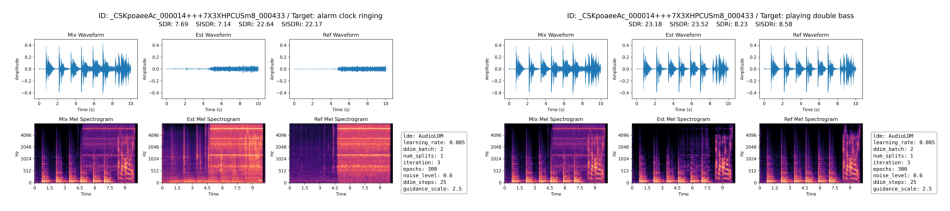

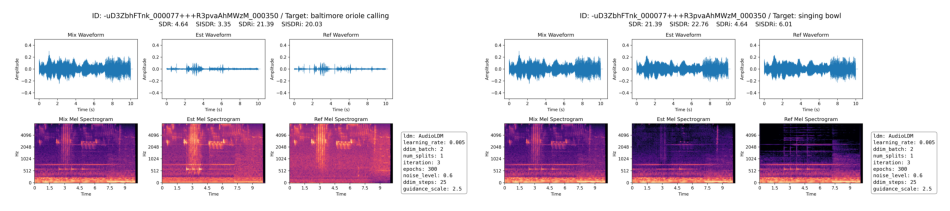

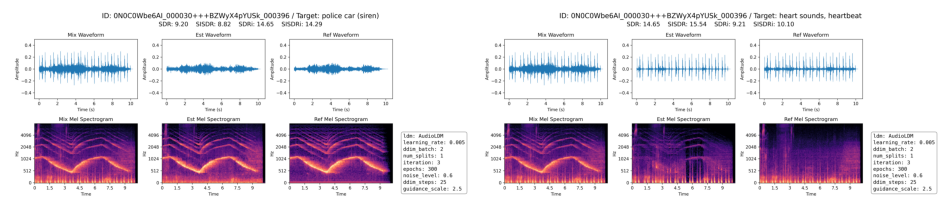

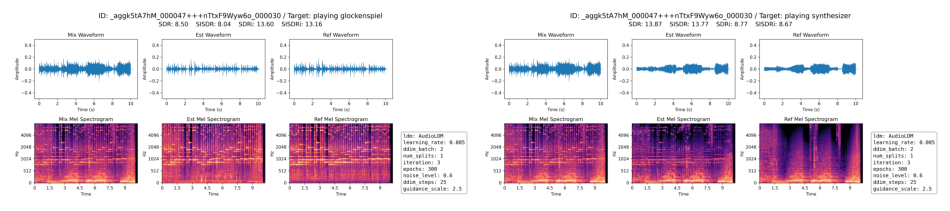

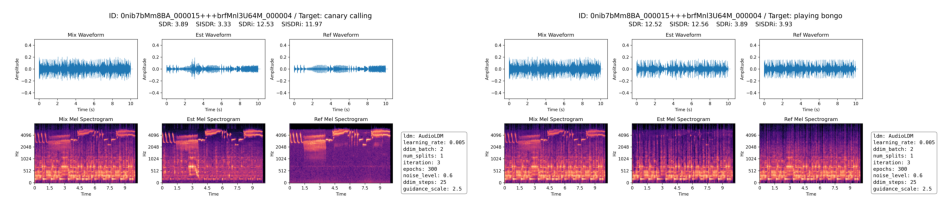

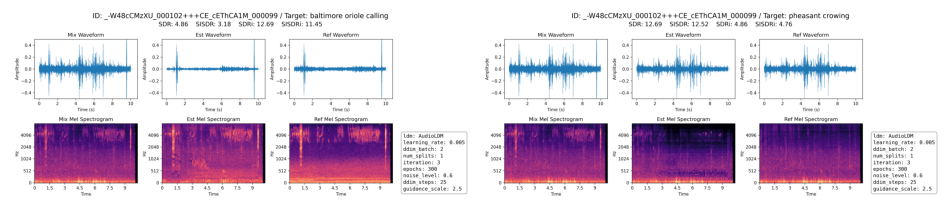

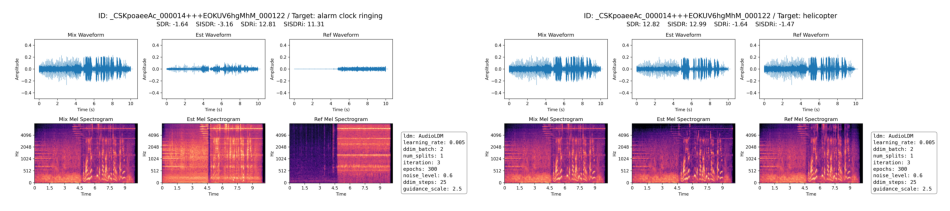

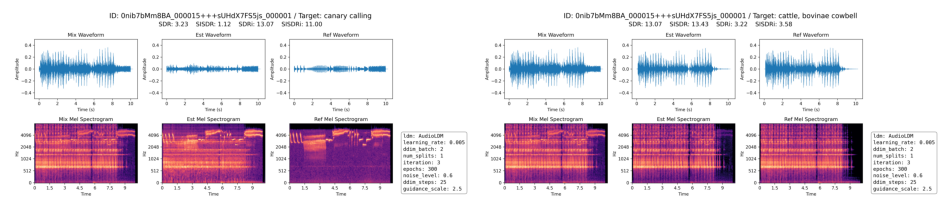

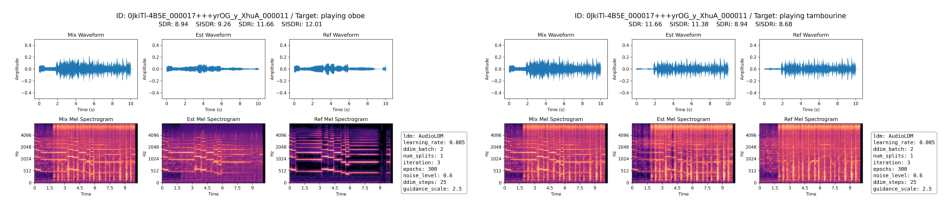

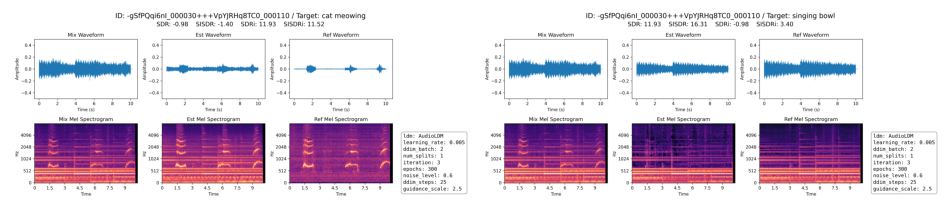

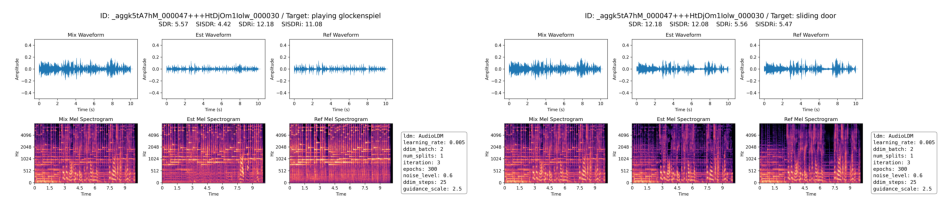

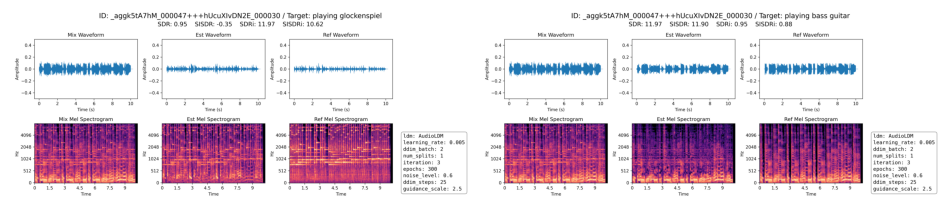

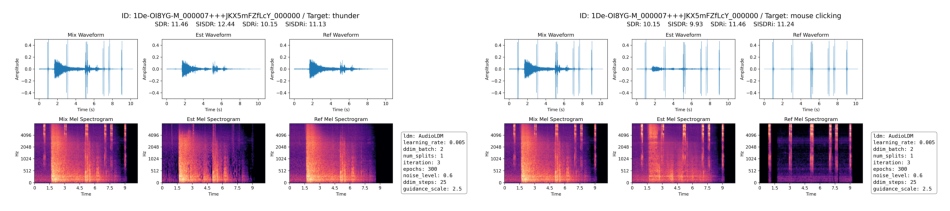

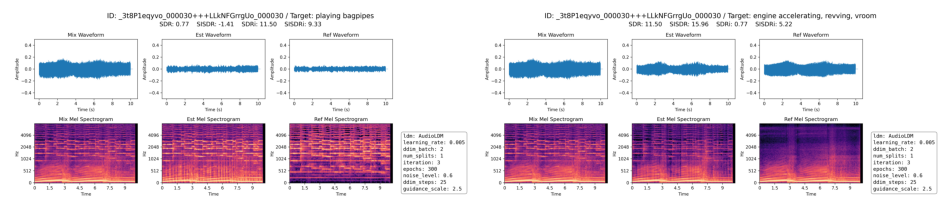

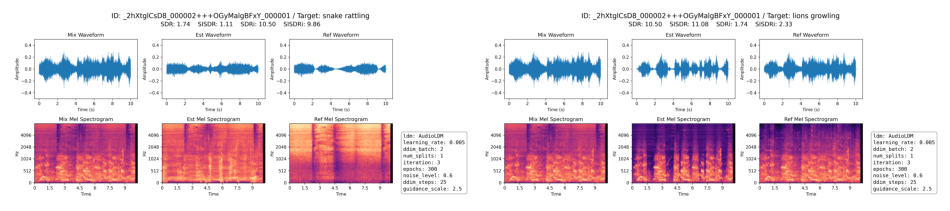

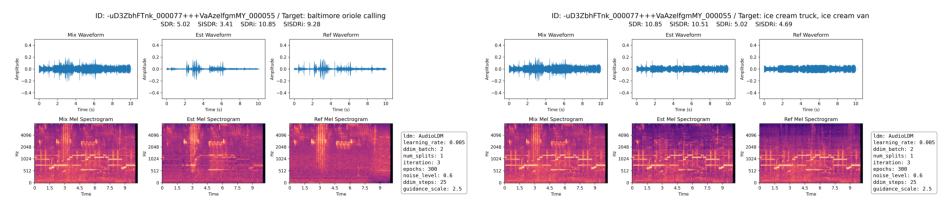

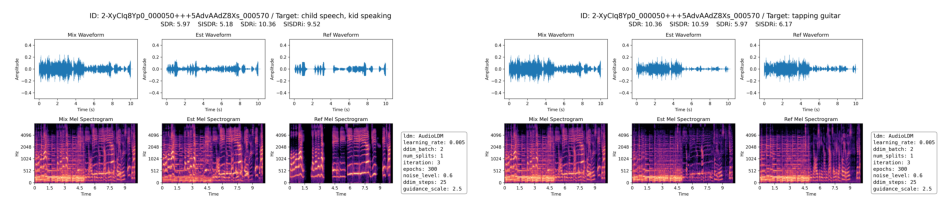

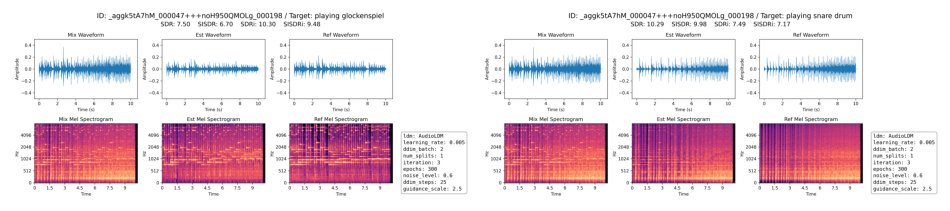

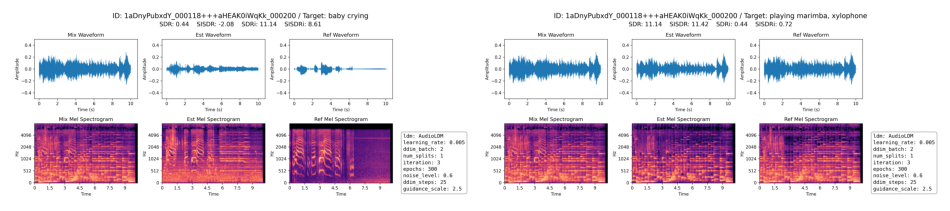

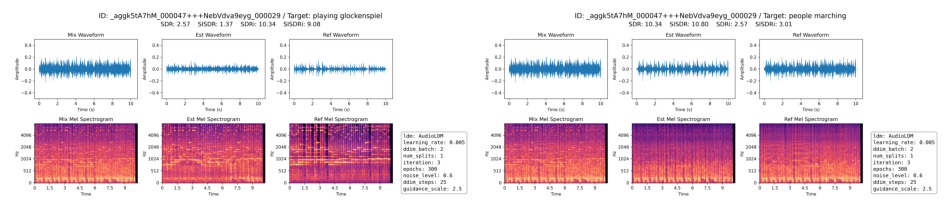

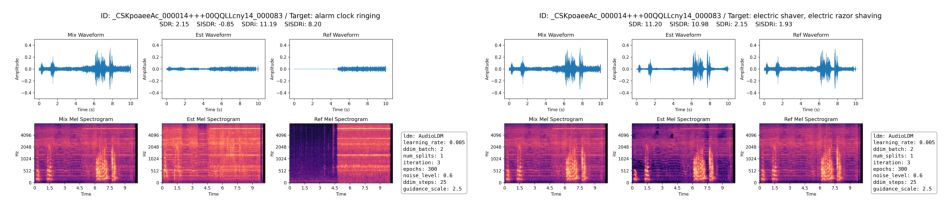

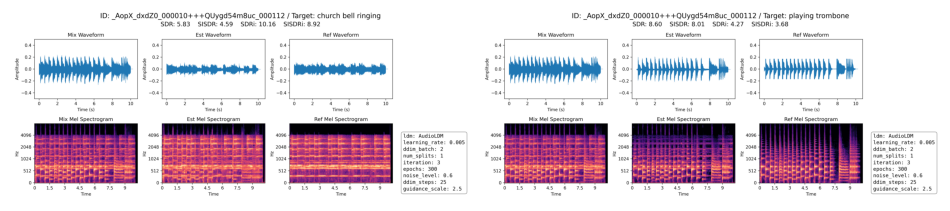

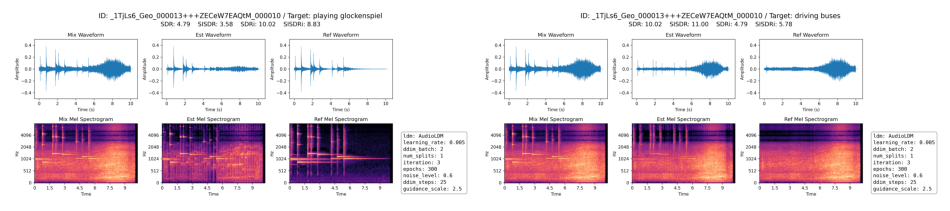

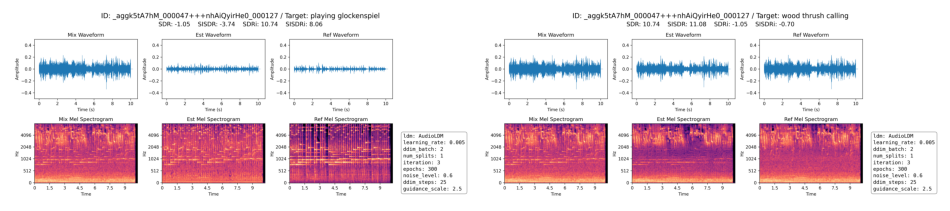

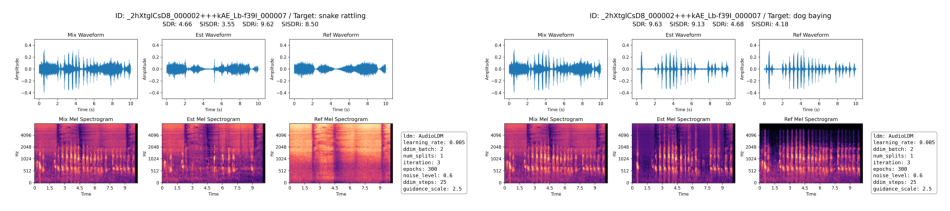

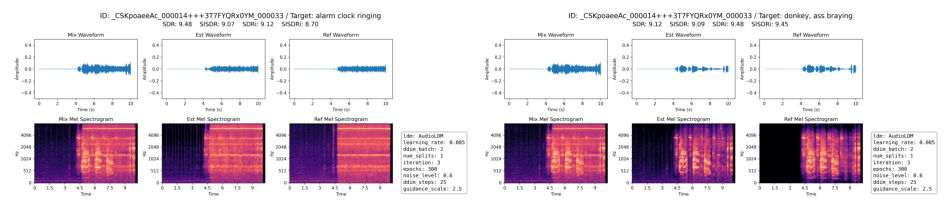

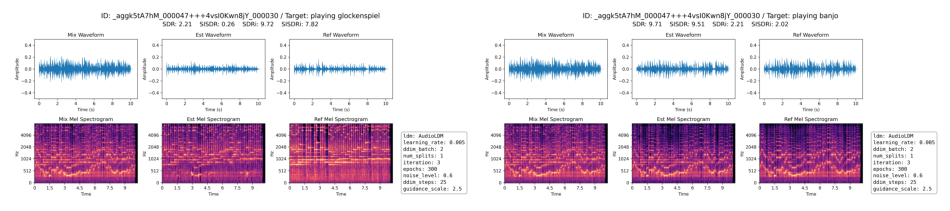

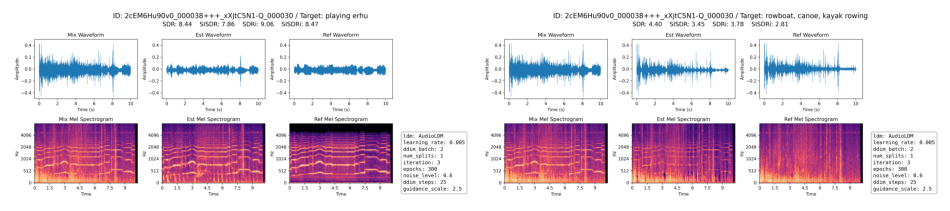

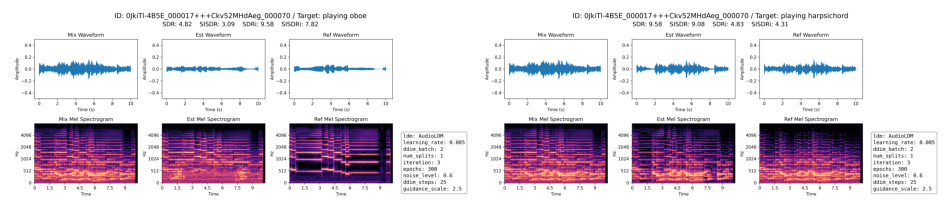

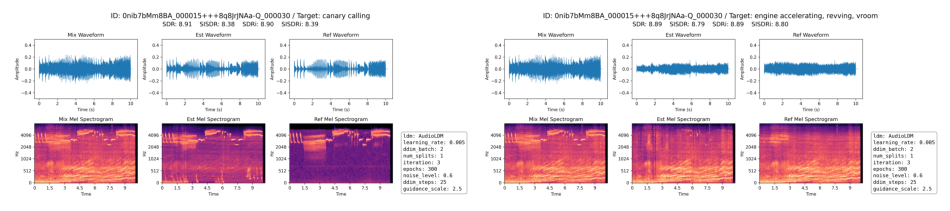

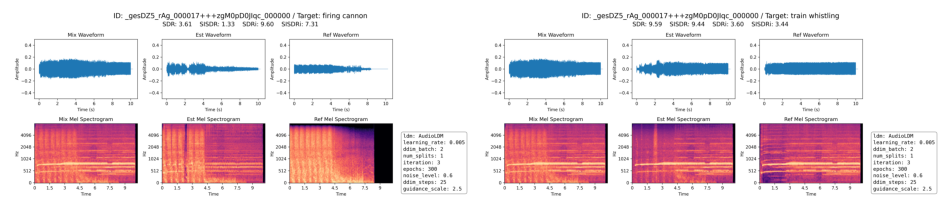

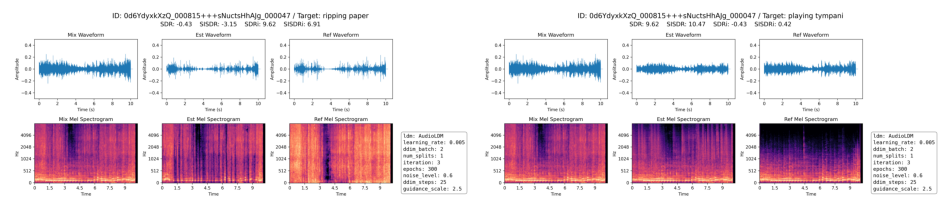

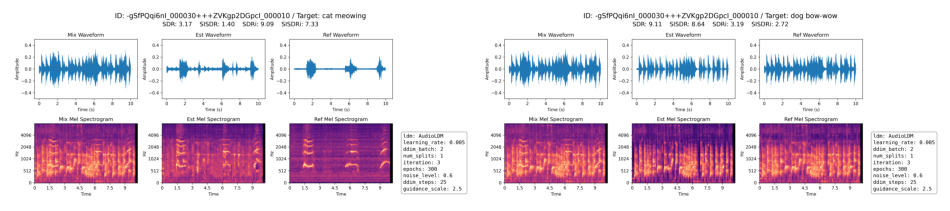

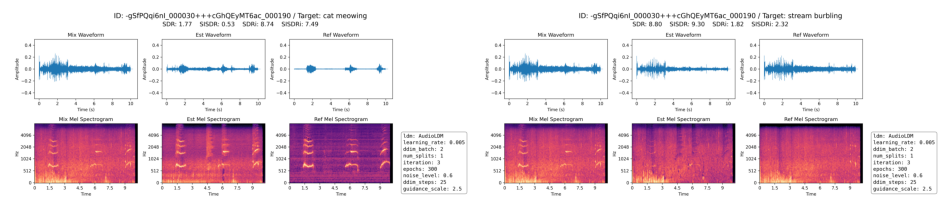

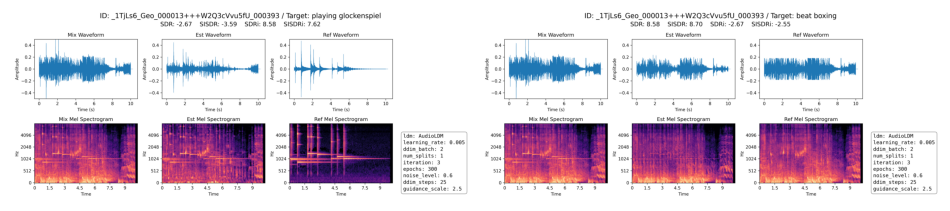

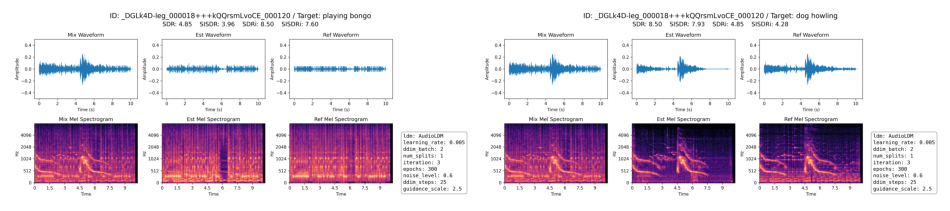

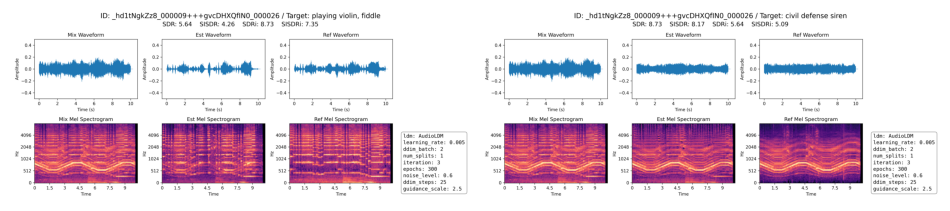

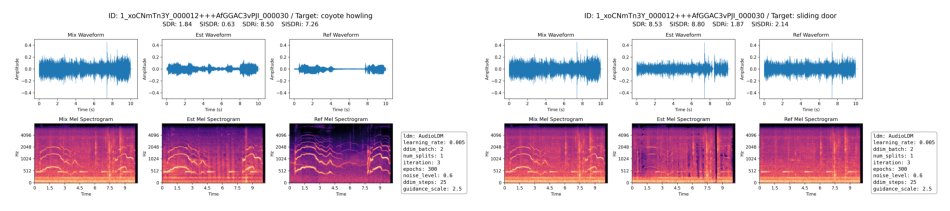

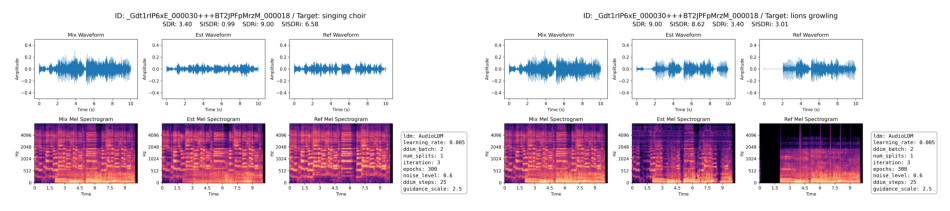

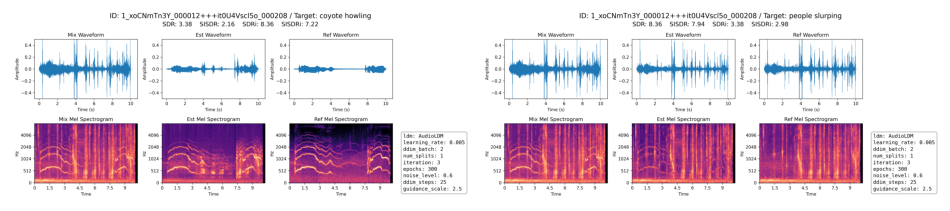

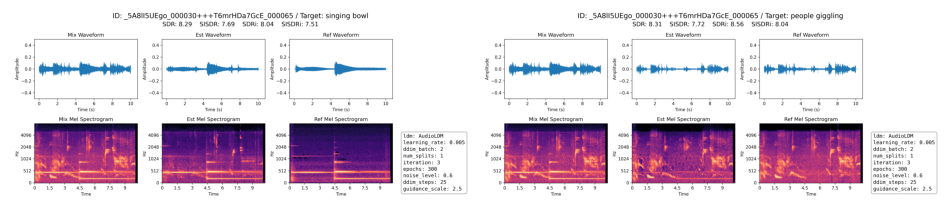

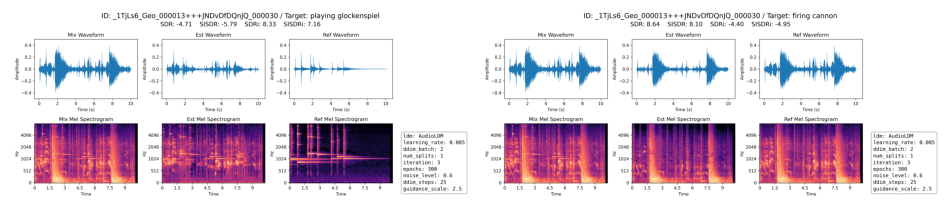

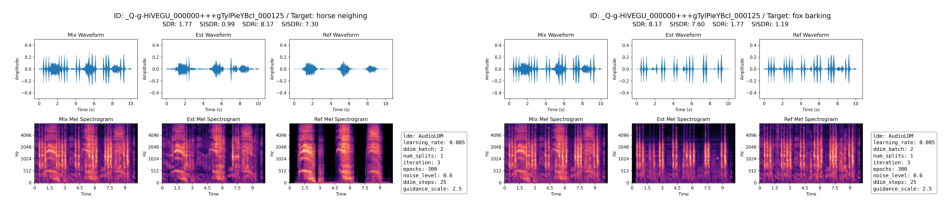

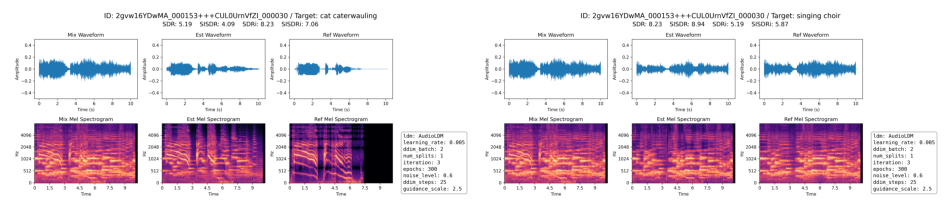

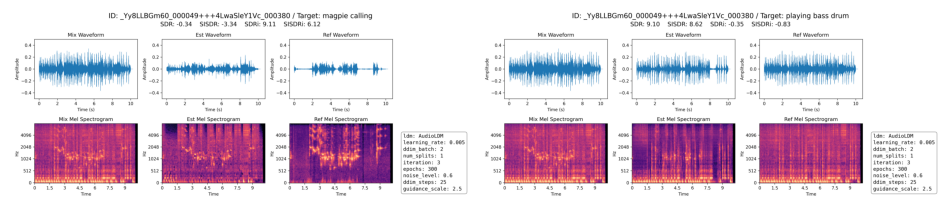

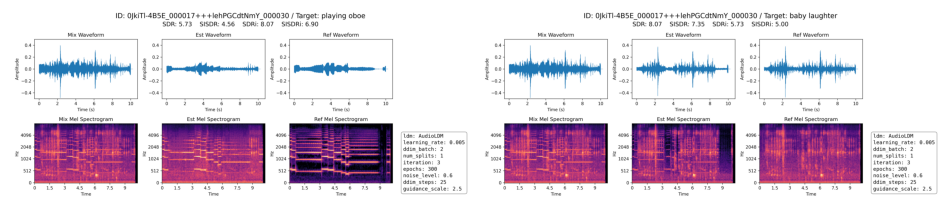

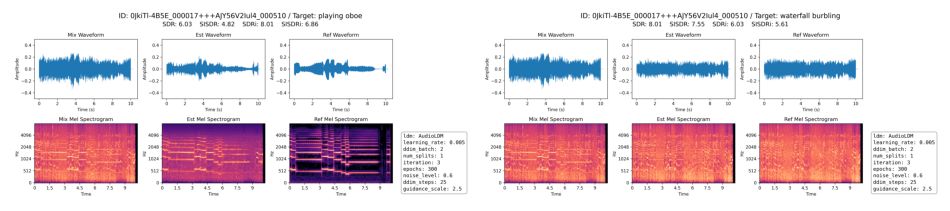

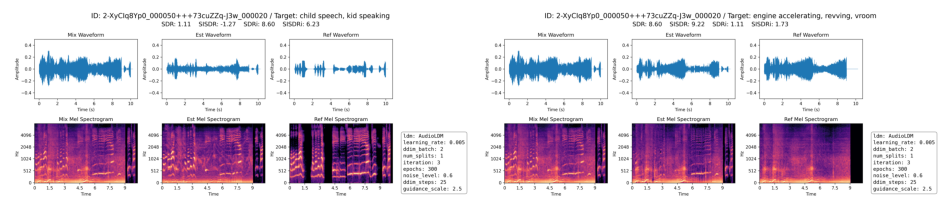

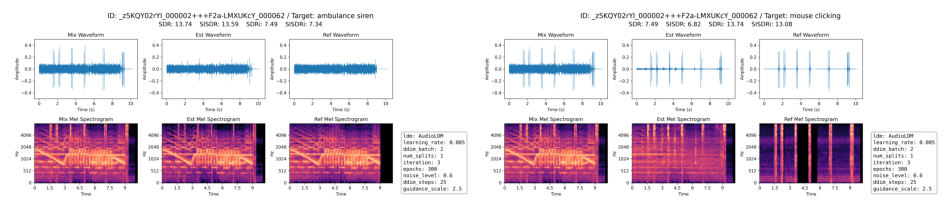

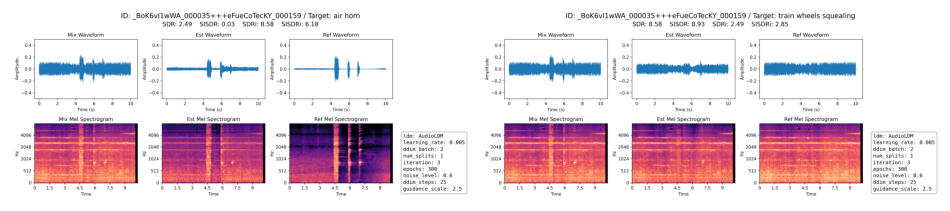

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# 예: file_id 리스트
file_ids = top50_file_ids  # 또는 원하는 file_id 리스트

for file_id in file_ids:
    img_paths = [
        f"./test/vgg_results/{file_id}/mel_joint_0.png",
        f"./test/vgg_results/{file_id}/mel_joint_1.png"
    ]
    
    imgs = []
    for path in img_paths:
        if os.path.exists(path):
            imgs.append(mpimg.imread(path))
        else:
            imgs.append(None)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for ax, img in zip(axes, imgs):
        if img is not None:
            ax.imshow(img)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.02, hspace=0)
    plt.show()


In [16]:
import os
import shutil
from PIL import Image
import pandas as pd

# 파일 경로 지정
metrics_csv_path = './test/vgg_plain.csv'  ##
info_csv_path = './src/benchmarks/metadata/vggsound_eval.csv'  ##

# 데이터 로딩
metrics_df = pd.read_csv(metrics_csv_path, header=None)
metrics_df['avg_3_4'] = (metrics_df[2] + metrics_df[3]) / 2
top50_indices = metrics_df['avg_3_4'].nlargest(50).index.tolist()
info_df = pd.read_csv(info_csv_path)

# top 50 file_ids 및 필요한 경로 컬럼 추출
top50_info = info_df.iloc[top50_indices]
file_ids = top50_info['file_id'].tolist()
mix_wavs = top50_info['mix_wav'].tolist()
s0_wavs = top50_info['s0_wav'].tolist()
s1_wavs = top50_info['s1_wav'].tolist()

for local_rank, idx in enumerate(top50_indices):
    score = int(metrics_df.iloc[idx]['avg_3_4'] * 100)
    score_str = f"{score:04d}"
    folder_name = f'score_{score}'
    save_folder = f'./best_samples_vgg_plain/{folder_name}'  ##
    os.makedirs(save_folder, exist_ok=True)

    file_id = file_ids[local_rank]
    src_folder = f'./test/vgg_results/{file_id}'

    # 1. 이미지 이어붙이기
    img0_path = os.path.join(src_folder, 'mel_plain_0.png')  ##
    img1_path = os.path.join(src_folder, 'mel_plain_1.png')  ##
    
    if os.path.exists(img0_path) and os.path.exists(img1_path):
        img0 = Image.open(img0_path)
        img1 = Image.open(img1_path)
        combined_img = Image.new('RGB', (max(img0.width, img1.width), img0.height + img1.height))
        combined_img.paste(img0, (0, 0))
        combined_img.paste(img1, (0, img0.height))
        combined_img.save(os.path.join(save_folder, 'combined.png'))
    else:
        print(f"[경고] 이미지 누락: {file_id}")

    # 2. sep_0.wav, sep_1.wav 복사
    for i in [0, 1]:
        sep_path = os.path.join(src_folder, f'pl_sep_{i}.wav')  ##
        if os.path.exists(sep_path):
            shutil.copy(sep_path, os.path.join(save_folder, f'sep_{i}.wav'))
        else:
            print(f"[경고] sep_{i}.wav 없음: {file_id}")

    # 3. mix/s0/s1 wav 복사 + 이름 지정
    wav_map = {
        'mix.wav': mix_wavs[local_rank],
        's0.wav': s0_wavs[local_rank],
        's1.wav': s1_wavs[local_rank]
    }

    for new_name, relative_path in wav_map.items():
        full_path = os.path.join('./data/vggsound', relative_path)
        if os.path.exists(full_path):
            shutil.copy(full_path, os.path.join(save_folder, new_name))
        else:
            print(f"[경고] WAV 파일 없음: {full_path}")



In [ ]:
import os
import csv
from tqdm import tqdm
import torchaudio
from src.utils import read_wav_file, plot_wav_mel, printing_sdrs

metadata_pth='./src/benchmarks/metadata/vggsound_eval.csv'
audio_dir='./data/vggsound'

with open(metadata_pth) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    eval_list = [row for row in csv_reader][1:]

for i, eval_data in enumerate(tqdm(eval_list)):
    if i not in common_indices:
        continue  # common_indices에 없으면 skip

    file_id, mix_wav, s0_wav, s0_text, s1_wav, s1_text = eval_data
    mixture_path = os.path.join(audio_dir, mix_wav)
    source_path = os.path.join(audio_dir, s0_wav)
    sep_pth = f"./test/vgg_result/{file_id}.wav"

    wav_mix = read_wav_file(filename=mixture_path, target_duration=10.24, target_sr=16000)
    wav_sep = read_wav_file(filename=sep_pth, target_duration=10.24, target_sr=16000)
    wav_gt = read_wav_file(filename=source_path, target_duration=10.24, target_sr=16000)

    scores = printing_sdrs(ref=wav_gt, mix=wav_mix, est=wav_sep, printing=False)
    wav_paths = [wav_mix, wav_sep, wav_gt]

    plot_wav_mel(
        wav_paths,
        save_path=f"./test/vgg_mels/{file_id}.png",
        score=scores,
        idx=file_id,
        config_path="./configs/DGMO.yaml"
    )

100%|██████████| 1000/1000 [01:33<00:00, 10.67it/s]


In [2]:
from src.utils import calculate_sdr, calculate_sisdr

sdr = calculate_sdr(wav_sep, wav_gt)
sisdr = calculate_sisdr(wav_sep, wav_gt)
print(f'SDR: {sdr:.4f}, SI-SDR: {sisdr:.4f}')

SDR: 1.8818, SI-SDR: 13.3102


In [6]:
sdr = calculate_sdr(_wav, _wav)
sisdr = calculate_sisdr(_wav, _wav)
print(f'SDR: {sdr:.4f}, SI-SDR: {sisdr:.4f}')

SDR: 77.1523, SI-SDR: 98.5334


In [7]:
import numpy as np
from scipy.signal import correlate

def align_wav_signals(wav1, wav2):
    assert wav1.shape == wav2.shape, "두 신호의 길이가 같아야 합니다."
    
    # 1D 배열로 변환
    wav1, wav2 = wav1.flatten(), wav2.flatten()
    
    # Cross-Correlation 계산
    correlation = correlate(wav1, wav2, mode="full")
    shift = correlation.argmax() - (len(wav1) - 1)  # 최대 상관점의 오프셋

    # shift 만큼 이동 (앞뒤 zero-padding 적용)
    if shift > 0:
        aligned_wav2 = np.pad(wav2[shift:], (0, shift), mode="constant")
    elif shift < 0:
        aligned_wav2 = np.pad(wav2[:shift], (-shift, 0), mode="constant")
    else:
        aligned_wav2 = wav2  # 이미 정렬됨

    return aligned_wav2, shift

aligned_wav2, applied_shift = align_wav_signals(wav, _wav)
sdr = calculate_sdr(wav, aligned_wav2)
sisdr = calculate_sisdr(wav, aligned_wav2)
print(f"적용된 시간 shift: {applied_shift} samples")
print(f'SDR: {sdr:.4f}, SI-SDR: {sisdr:.4f}')


적용된 시간 shift: 0 samples
SDR: 34.4945, SI-SDR: 49.7118
